# Exploratory Data Analysis – Triadic Human–AI Delegation Dataset

This notebook explores the synthetic dataset generated by the **Triadic Delegation Simulator**, which models dynamic delegation behavior between managers, AI systems, and human employees.

**Key questions:**
- How are governance orientations distributed across managers?
- How does delegation behavior (acceptance, override, escalation) vary by governance mode?
- How do delegation dynamics evolve over time (26 periods)?
- What is the effect of the transparency intervention (period 13)?
- How do latent willingness-to-delegate states transition over time?

---

### Table of Contents

1. [Import Required Libraries](#1.-Import-Required-Libraries)
2. [Load and Inspect Data](#2.-Load-and-Inspect-Data)
3. [Data Cleaning and Preprocessing](#3.-Data-Cleaning-and-Preprocessing)
4. [Exploratory Data Analysis with Descriptive Statistics](#4.-Exploratory-Data-Analysis-with-Descriptive-Statistics)
   - [4.1 Manager-Level Summary](#4.1-Manager-Level-Summary)
   - [4.2 Panel-Level Descriptive Statistics](#4.2-Panel-Level-Descriptive-Statistics)
5. [Data Visualization](#5.-Data-Visualization)
   - [5.1 Manager Trait Distributions](#5.1-Manager-Trait-Distributions)
   - [5.2 Delegation Behavior by Governance Mode](#5.2-Delegation-Behavior-by-Governance-Mode)
6. [Filtering and Grouping — Time Series Dynamics](#6.-Filtering-and-Grouping-—-Time-Series-Dynamics)
   - [6.1 Delegation Trends Over Periods](#6.1-Delegation-Trends-Over-Periods-(by-Governance-Mode))
   - [6.2 Pre vs. Post Transparency Intervention](#6.2-Pre-vs.-Post-Transparency-Intervention)
   - [6.3 Latent State Transitions Over Time](#6.3-Latent-State-Transitions-Over-Time)
7. [Correlation Analysis](#7.-Correlation-Analysis)

---

**Dataset tables:**
| Table | Description |
|---|---|
| `manager_master` | Manager traits and governance modes |
| `employee_master` | Employee and team characteristics |
| `ai_system_master` | AI system configuration |
| `site_master` | Site-level metadata |
| `panel_manager_period` | Period-level panel data (main analysis table) |
| `panel_employee_period` | Period-level employee panel data |
| `decision_episode` | Episode-level delegation decisions |
| `execution_episode` | Episode-level task execution |

## 1. Import Required Libraries

In [ ]:
# type: ignore
# pyright: ignore[reportUnknownMemberType,reportUnknownArgumentType,reportUnknownVariableType]
%pip install matplotlib seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Plot style
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["figure.dpi"] = 120

DATA_PATH = Path("../triadic_simulation/data/Triadic_Delegation_Dataset_SYNTH.xlsx")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Load and Inspect Data

Load all six sheets from the synthetic dataset workbook.

In [5]:
# Load all sheets
sheets = [
    "manager_master",
    "employee_master",
    "ai_system_master",
    "panel_manager_period",
    "decision_episode",
    "execution_episode",
]

dfs = {name: pd.read_excel(DATA_PATH, sheet_name=name) for name in sheets}

# Quick overview
for name, df in dfs.items():
    print(f"\n{'='*60}")
    print(f"  {name}  |  shape: {df.shape}")
    print(f"{'='*60}")
    print(df.dtypes)
    print(f"\nFirst 3 rows:")
    display(df.head(3))


  manager_master  |  shape: (120, 10)
manager_id                  str
role                        str
function                    str
seniority_years         float64
risk_aversion_index     float64
baseline_ai_attitude    float64
org_unit_id                 str
site_id                     str
governance_mode             str
high_pressure             int64
dtype: object

First 3 rows:


,manager_id,role,function,seniority_years,risk_aversion_index,baseline_ai_attitude,org_unit_id,site_id,governance_mode,high_pressure
0,M0001,operations_manager,supply_chain,6.668765,0.853411,-0.160045,OU08,S007,fearful_exclusion,0
1,M0002,operations_manager,supply_chain,6.661226,0.685796,-0.066765,OU01,S003,fearful_exclusion,0
2,M0003,operations_manager,supply_chain,2.977426,0.182890,0.430951,OU08,S005,opportunistic_teaming,1



  employee_master  |  shape: (680, 7)
employee_id                str
manager_id                 str
site_id                    str
role                       str
experience_years       float64
ai_familiarity         float64
task_specialization        str
dtype: object

First 3 rows:


,employee_id,manager_id,site_id,role,experience_years,ai_familiarity,task_specialization
0,E000001,M0001,S007,dispatcher,10.424905,0.709822,inbound
1,E000002,M0001,S007,planner,5.981480,0.626023,crossdock
2,E000003,M0001,S007,inventory_analyst,3.352032,0.371038,outbound



  ai_system_master  |  shape: (1, 5)
ai_version                          str
deployment_date                     str
autonomy_level                      str
explanation_capability              str
confidence_calibration_score    float64
dtype: object

First 3 rows:


,ai_version,deployment_date,autonomy_level,explanation_capability,confidence_calibration_score
0,v1,2017-01-01,high,(varies by period),0.75



  panel_manager_period  |  shape: (3120, 20)
manager_id                         str
period_id                        int64
ai_decision_authority_share    float64
override_rate                  float64
escalation_rate                float64
decision_latency_avg           float64
service_level_delta            float64
inventory_cost_delta           float64
expedite_cost_delta            float64
error_incident_count             int64
target_difficulty              float64
performance_pressure_index     float64
recent_negative_shock            int64
task_complexity_index          float64
demand_volatility              float64
supply_disruption_count          int64
forecast_accuracy_mape         float64
ai_version                         str
latent_state                     int64
latent_state_next                int64
dtype: object

First 3 rows:


,manager_id,period_id,ai_decision_authority_share,override_rate,escalation_rate,decision_latency_avg,service_level_delta,inventory_cost_delta,expedite_cost_delta,error_incident_count,target_difficulty,performance_pressure_index,recent_negative_shock,task_complexity_index,demand_volatility,supply_disruption_count,forecast_accuracy_mape,ai_version,latent_state,latent_state_next
0,M0001,1,0.491228,0.508772,0.263158,10.643710,1.241963,2.688170,2.910362,0,0.680719,0.434398,0,0.698746,0.468305,1,0.317673,v1,1,2
1,M0002,1,0.333333,0.666667,0.117647,7.760712,-0.677167,2.963804,1.330301,0,0.587491,0.417406,1,0.370609,0.210441,0,0.253889,v1,1,2
2,M0003,1,0.707692,0.292308,0.153846,5.199225,-0.532959,2.837809,0.206608,0,0.998534,0.847799,0,0.217614,0.216493,0,0.202896,v1,2,2



  decision_episode  |  shape: (138177, 13)
episode_id                    str
manager_id                    str
period_id                   int64
site_id                       str
ai_version                    str
ai_recommendation_type        str
ai_confidence             float64
ai_uncertainty            float64
explanation_provided        int64
manager_action                str
override_flag               int64
escalation_flag             int64
time_to_decision          float64
dtype: object

First 3 rows:


,episode_id,manager_id,period_id,site_id,ai_version,ai_recommendation_type,ai_confidence,ai_uncertainty,explanation_provided,manager_action,override_flag,escalation_flag,time_to_decision
0,EP_M0001_001_001,M0001,1,S007,v1,expedite,0.383884,0.702310,0,accept,0,1,14.690552
1,EP_M0001_001_002,M0001,1,S007,v1,reorder,0.586045,0.434401,0,accept,0,0,7.240672
2,EP_M0001_001_003,M0001,1,S007,v1,reroute,0.556590,0.499678,0,accept,0,0,7.910554



  execution_episode  |  shape: (138177, 10)
execution_id                              str
episode_id                                str
employee_id                               str
site_id                                   str
execution_mode                            str
ai_support_level                      float64
employee_override_during_execution      int64
local_adjustment_flag                   int64
execution_time                        float64
execution_error_flag                    int64
dtype: object

First 3 rows:


,execution_id,episode_id,employee_id,site_id,execution_mode,ai_support_level,employee_override_during_execution,local_adjustment_flag,execution_time,execution_error_flag
0,EX_M0001_001_001,EP_M0001_001_001,E000004,S007,ai,0.771011,0,0,17.475667,1
1,EX_M0001_001_002,EP_M0001_001_002,E000001,S007,ai,1.000000,0,1,18.166010,0
2,EX_M0001_001_003,EP_M0001_001_003,E000006,S007,ai,1.000000,0,1,16.234397,0


## 3. Data Cleaning and Preprocessing

Check for missing values and data quality across all tables.

In [7]:
# Check missing values across all tables
for name, df in dfs.items():
    missing = df.isnull().sum()
    total_missing = missing.sum()
    print(f"{name}: {total_missing} missing values")
    if total_missing > 0:
        print(missing[missing > 0])
    print()

# Check for duplicates in key ID columns
print("Duplicate manager IDs:", dfs["manager_master"]["manager_id"].duplicated().sum())
print("Duplicate decision episodes:", dfs["decision_episode"]["episode_id"].duplicated().sum())
print("Duplicate execution episodes:", dfs["execution_episode"]["execution_id"].duplicated().sum())

# Assign convenience references
mgr = dfs["manager_master"]
panel = dfs["panel_manager_period"]
dec = dfs["decision_episode"]
exe = dfs["execution_episode"]

manager_master: 0 missing values

employee_master: 0 missing values

ai_system_master: 0 missing values

panel_manager_period: 0 missing values

decision_episode: 0 missing values

execution_episode: 0 missing values

Duplicate manager IDs: 0
Duplicate decision episodes: 0
Duplicate execution episodes: 0


## 4. Exploratory Data Analysis with Descriptive Statistics

### 4.1 Manager-Level Summary

In [8]:
# Governance mode distribution
print("Governance Mode Distribution:")
print(mgr["governance_mode"].value_counts())
print(f"\n% breakdown:\n{mgr['governance_mode'].value_counts(normalize=True).round(3) * 100}")

print("\n" + "="*60)
print("Manager Traits by Governance Mode:")
print("="*60)
mgr.groupby("governance_mode")[["baseline_ai_attitude", "risk_aversion_index"]].describe().round(3)

Governance Mode Distribution:
governance_mode
fearful_exclusion        41
controlled_opening       40
opportunistic_teaming    39
Name: count, dtype: int64

% breakdown:
governance_mode
fearful_exclusion        34.2
controlled_opening       33.3
opportunistic_teaming    32.5
Name: proportion, dtype: float64

Manager Traits by Governance Mode:


baseline_ai_attitude                                     \
                                     count   mean    std    min    25%    50%   
governance_mode                                                                 
controlled_opening                    40.0 -0.093  0.322 -0.870 -0.317 -0.029   
fearful_exclusion                     41.0 -0.585  0.311 -1.000 -0.810 -0.629   
opportunistic_teaming                 39.0  0.478  0.292 -0.075  0.265  0.498   

                                    risk_aversion_index                       \
                         75%    max               count   mean    std    min   
governance_mode                                                                
controlled_opening     0.079  0.449                40.0  0.552  0.133  0.299   
fearful_exclusion     -0.362  0.190                41.0  0.739  0.114  0.458   
opportunistic_teaming  0.690  1.000                39.0  0.339  0.158  0.000   

                                                   
                         25%    50%    75%    max  
governance_mode                                    
controlled_opening     0.479  0.543  0.630  0.844  
fearful_exclusion      0.679  0.743  0.801  0.958  
opportunistic_teaming  0.228  0.310  0.443  0.731

### 4.2 Panel-Level Descriptive Statistics

Key delegation and performance variables across all manager-period observations.

In [11]:
key_panel_cols = [
    "ai_decision_authority_share",
    "override_rate",
    "escalation_rate",
    "decision_latency_avg",
    "performance_pressure_index",
    "task_complexity_index",
    "demand_volatility",
    "service_level_delta",
    "inventory_cost_delta",
    "expedite_cost_delta",
    "error_incident_count",
]

panel[key_panel_cols].describe().round(4).T

,count,mean,std,min,25%,50%,75%,max
ai_decision_authority_share,3120.0,0.4569,0.2905,0.0000,0.1633,0.4732,0.7382,1.0000
override_rate,3120.0,0.5431,0.2905,0.0000,0.2618,0.5268,0.8367,1.0000
escalation_rate,3120.0,0.1765,0.0737,0.0000,0.1245,0.1707,0.2222,0.4478
decision_latency_avg,3120.0,9.1338,2.3188,3.1823,7.4429,9.0187,10.8260,16.0471
performance_pressure_index,3120.0,0.6052,0.1708,0.2068,0.4547,0.6158,0.7525,0.9664
task_complexity_index,3120.0,0.4967,0.2195,0.0128,0.3249,0.4937,0.6685,0.9857
demand_volatility,3120.0,0.4116,0.1846,0.0100,0.2683,0.3927,0.5370,1.0000
service_level_delta,3120.0,-0.1085,0.8957,-3.1122,-0.7177,-0.1284,0.4821,3.5197
inventory_cost_delta,3120.0,2.1205,0.8095,-1.5315,1.5732,2.1228,2.6712,4.7996
expedite_cost_delta,3120.0,2.1163,0.7986,-0.5533,1.5738,2.1148,2.6422,5.2013


## 5. Data Visualization

### 5.1 Manager Trait Distributions

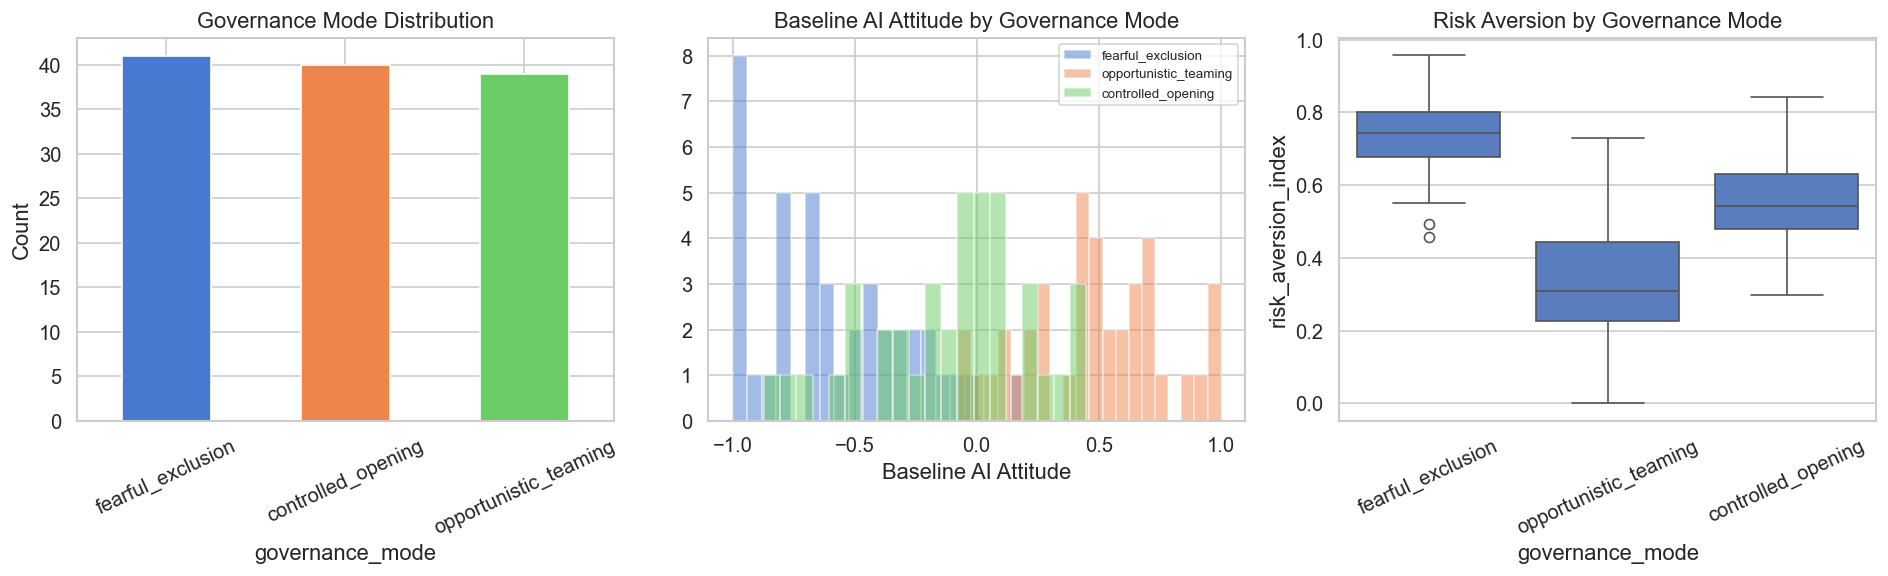

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Governance mode bar chart
mgr["governance_mode"].value_counts().plot.bar(ax=axes[0], color=list(sns.color_palette("muted", 3)))
axes[0].set_title("Governance Mode Distribution")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x", rotation=25)

# Baseline AI attitude histogram by governance mode
for mode in mgr["governance_mode"].unique():
    subset = mgr[mgr["governance_mode"] == mode]
    axes[1].hist(subset["baseline_ai_attitude"], bins=20, alpha=0.5, label=mode)
axes[1].set_title("Baseline AI Attitude by Governance Mode")
axes[1].set_xlabel("Baseline AI Attitude")
axes[1].legend(fontsize=8)

# Risk aversion by governance mode
sns.boxplot(data=mgr, x="governance_mode", y="risk_aversion_index", ax=axes[2])
axes[2].set_title("Risk Aversion by Governance Mode")
axes[2].tick_params(axis="x", rotation=25)

plt.tight_layout()
plt.show()

### 5.2 Delegation Behavior by Governance Mode

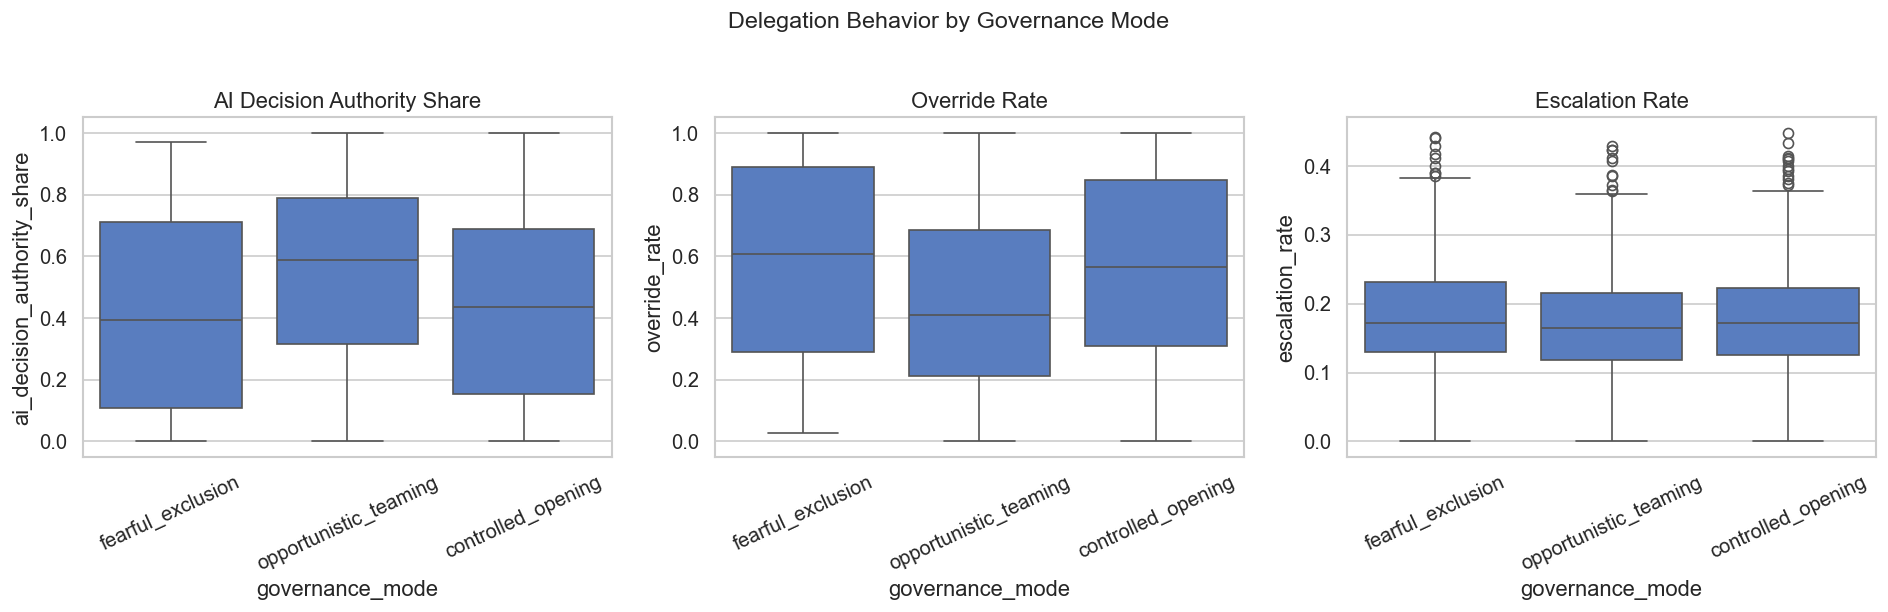

In [14]:
# Merge governance_mode into panel for plotting
panel = panel.merge(mgr[["manager_id", "governance_mode"]], on="manager_id", how="left") if "governance_mode" not in panel.columns else panel

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

sns.boxplot(data=panel, x="governance_mode", y="ai_decision_authority_share", ax=axes[0])
axes[0].set_title("AI Decision Authority Share")
axes[0].tick_params(axis="x", rotation=25)

sns.boxplot(data=panel, x="governance_mode", y="override_rate", ax=axes[1])
axes[1].set_title("Override Rate")
axes[1].tick_params(axis="x", rotation=25)

sns.boxplot(data=panel, x="governance_mode", y="escalation_rate", ax=axes[2])
axes[2].set_title("Escalation Rate")
axes[2].tick_params(axis="x", rotation=25)

plt.suptitle("Delegation Behavior by Governance Mode", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 6. Filtering and Grouping — Time Series Dynamics

### 6.1 Delegation Trends Over Periods (by Governance Mode)

The vertical dashed line marks the **transparency intervention at period 13**.

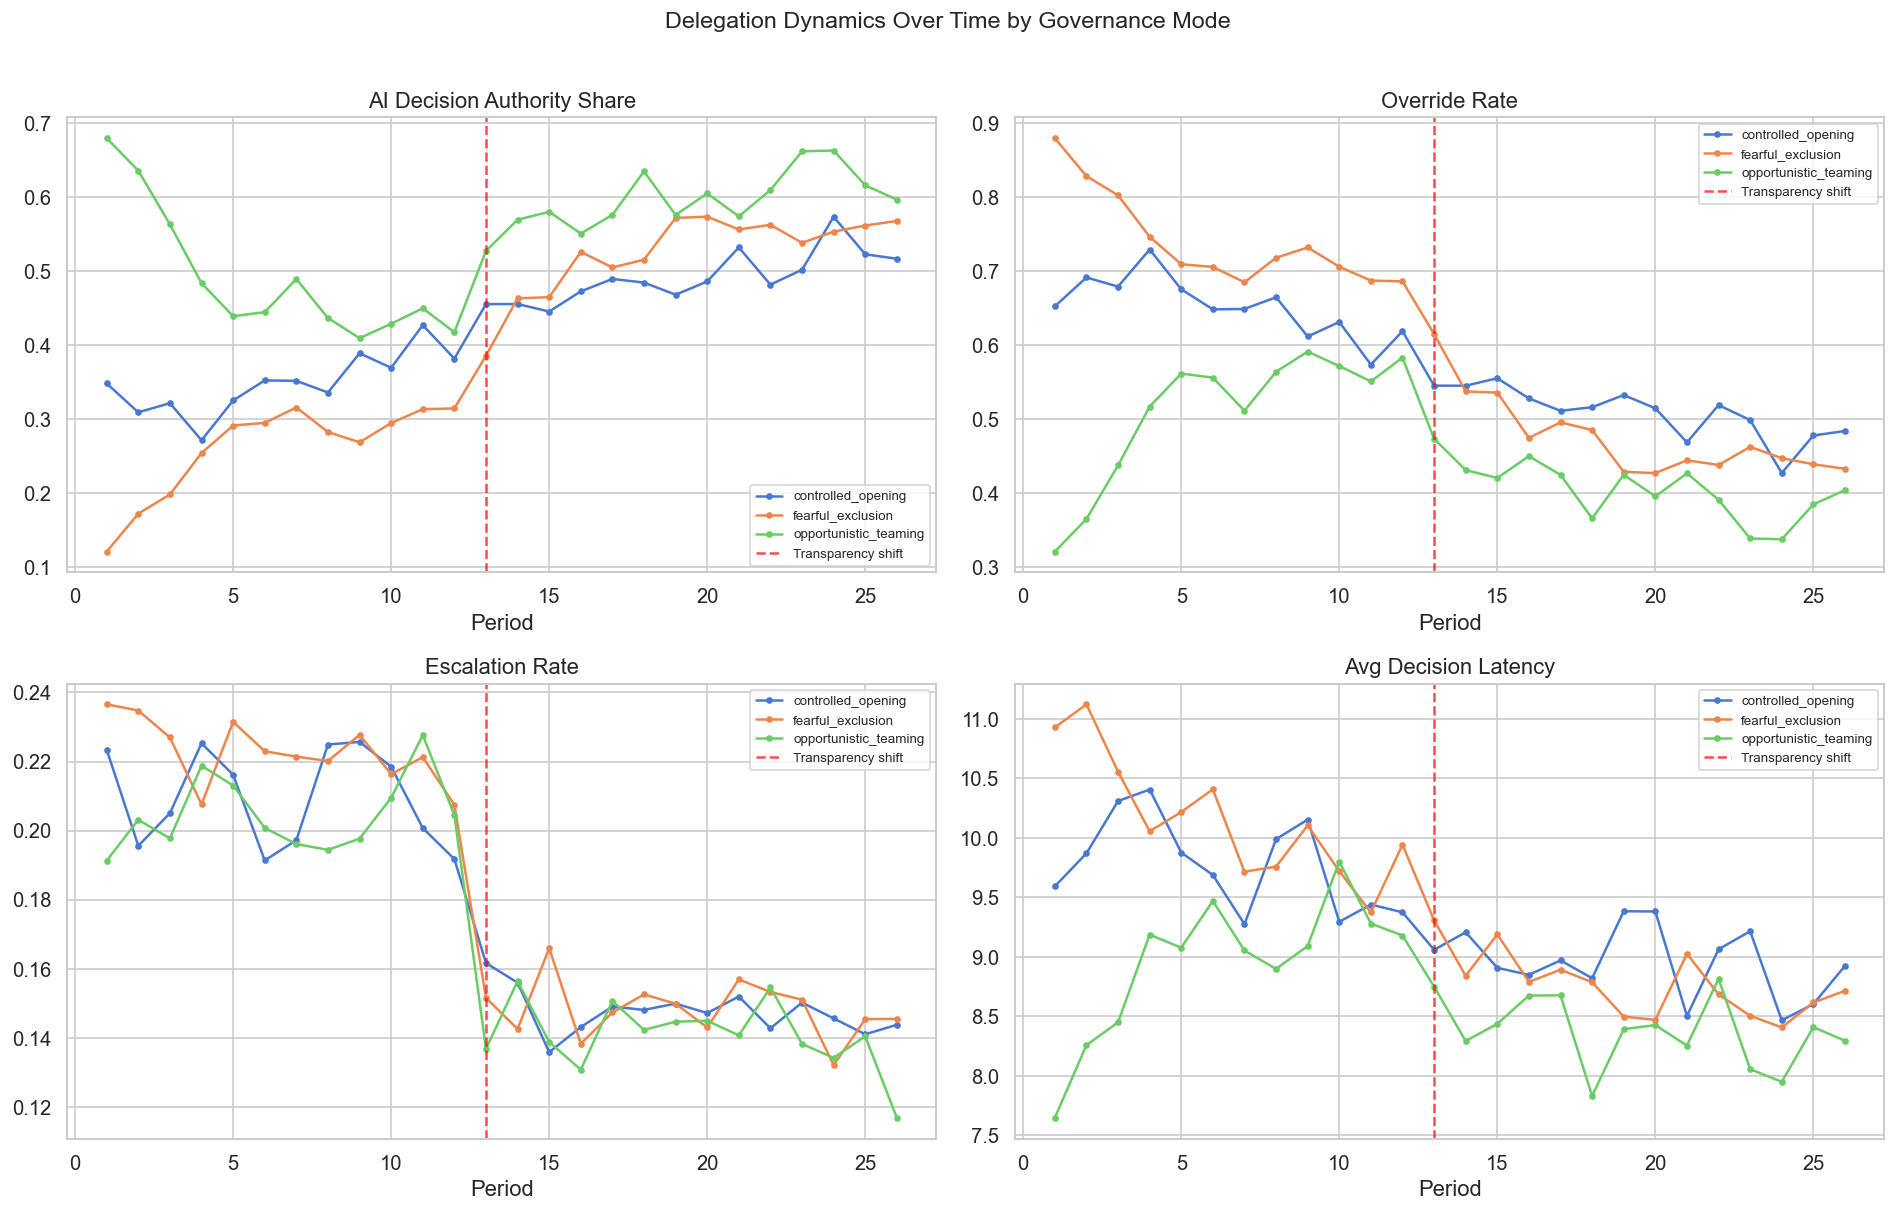

In [18]:
# Aggregate by period and governance mode
ts = panel.groupby(["period_id", "governance_mode"]).agg(
    mean_authority=("ai_decision_authority_share", "mean"),
    mean_override=("override_rate", "mean"),
    mean_escalation=("escalation_rate", "mean"),
    mean_latency=("decision_latency_avg", "mean"),
).reset_index()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for mode in ts["governance_mode"].unique():
    subset = ts[ts["governance_mode"] == mode]
    axes[0, 0].plot(subset["period_id"], subset["mean_authority"], label=mode, marker="o", markersize=3)
    axes[0, 1].plot(subset["period_id"], subset["mean_override"], label=mode, marker="o", markersize=3)
    axes[1, 0].plot(subset["period_id"], subset["mean_escalation"], label=mode, marker="o", markersize=3)
    axes[1, 1].plot(subset["period_id"], subset["mean_latency"], label=mode, marker="o", markersize=3)

titles = ["AI Decision Authority Share", "Override Rate", "Escalation Rate", "Avg Decision Latency"]
for ax, title in zip(axes.flat, titles):
    ax.axvline(x=13, color="red", linestyle="--", alpha=0.7, label="Transparency shift")
    ax.set_title(title)
    ax.set_xlabel("Period")
    ax.legend(fontsize=8)

plt.suptitle("Delegation Dynamics Over Time by Governance Mode", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

### 6.2 Pre vs. Post Transparency Intervention

Compare delegation behavior before and after the transparency shift at period 13.

Mean values by phase and governance mode:



ai_decision_authority_share  \
phase             governance_mode                                      
Post-Transparency controlled_opening                          0.4916   
                  fearful_exclusion                           0.5245   
                  opportunistic_teaming                       0.5955   
Pre-Transparency  controlled_opening                          0.3483   
                  fearful_exclusion                           0.2598   
                  opportunistic_teaming                       0.4896   

                                         override_rate  escalation_rate  \
phase             governance_mode                                         
Post-Transparency controlled_opening            0.5084           0.1476   
                  fearful_exclusion             0.4755           0.1483   
                  opportunistic_teaming         0.4045           0.1408   
Pre-Transparency  controlled_opening            0.6517           0.2096   
                  fearful_exclusion             0.7402           0.2229   
                  opportunistic_teaming         0.5104           0.2046   

                                         decision_latency_avg  
phase             governance_mode                              
Post-Transparency controlled_opening                   8.9543  
                  fearful_exclusion                    8.7666  
                  opportunistic_teaming                8.3762  
Pre-Transparency  controlled_opening                   9.7728  
                  fearful_exclusion                   10.1588  
                  opportunistic_teaming                8.9496

C:\Users\Admin\AppData\Local\Temp\ipykernel_8796\3806347315.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=panel, x="governance_mode", y=col, hue="phase", ax=axes[i], ci=95)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8796\3806347315.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=panel, x="governance_mode", y=col, hue="phase", ax=axes[i], ci=95)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8796\3806347315.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=panel, x="governance_mode", y=col, hue="phase", ax=axes[i], ci=95)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8796\3806347315.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=panel, x="governance_mode", y=col, hue="phase", ax=axes[i],

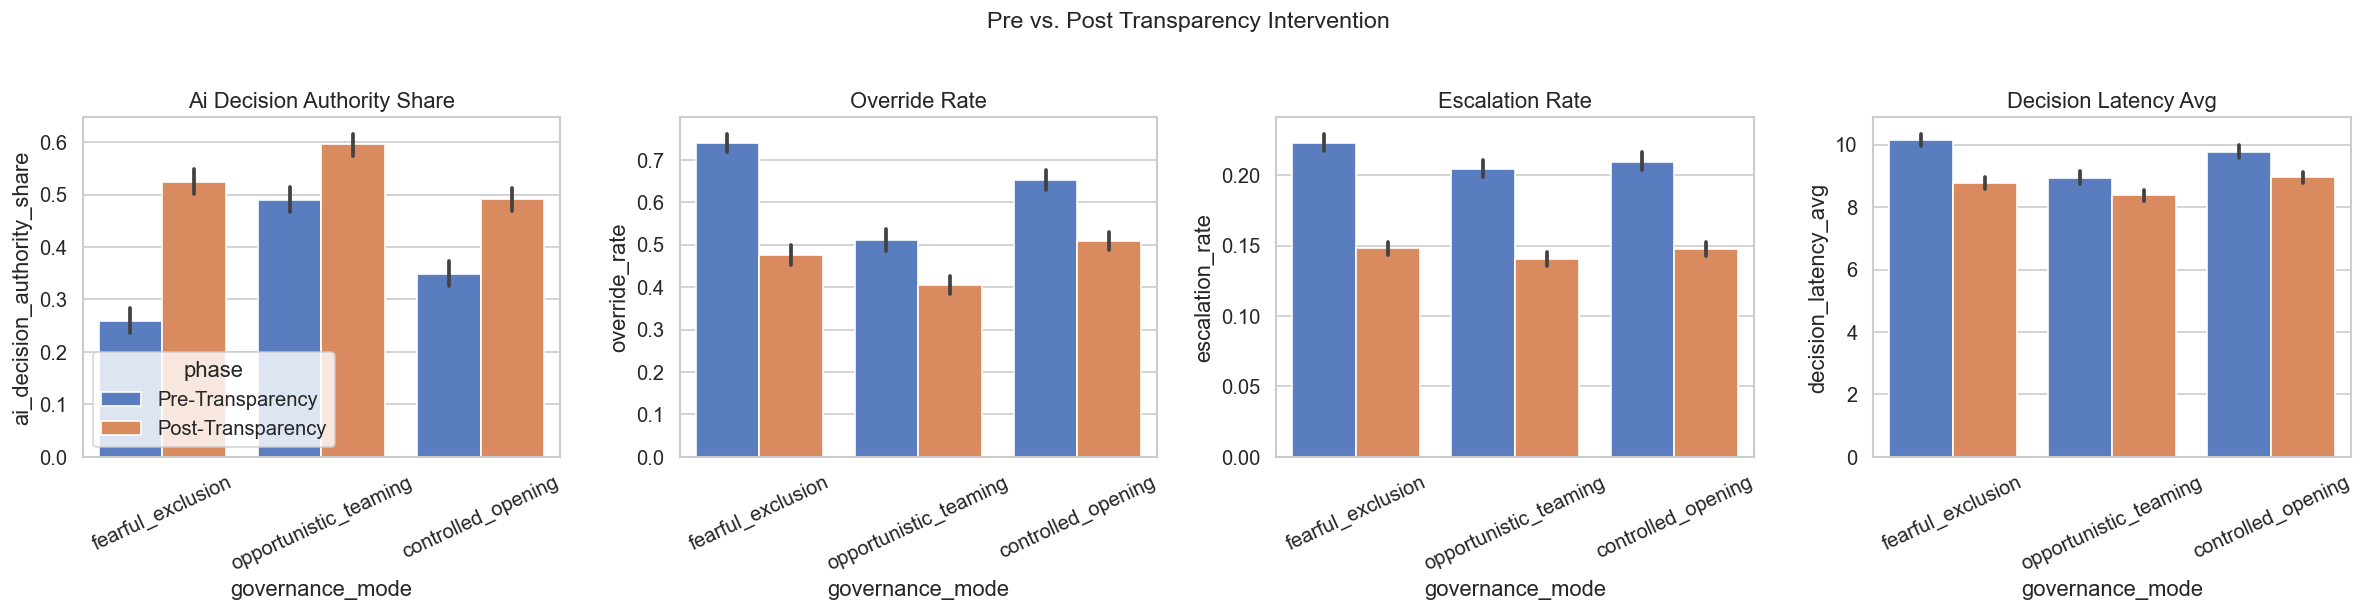

In [19]:
# Create pre/post indicator
panel["phase"] = np.where(panel["period_id"] < 13, "Pre-Transparency", "Post-Transparency")

compare_cols = ["ai_decision_authority_share", "override_rate", "escalation_rate", "decision_latency_avg"]

print("Mean values by phase and governance mode:\n")
comparison = panel.groupby(["phase", "governance_mode"])[compare_cols].mean().round(4)
display(comparison)

# Visualize pre vs. post
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, col in enumerate(compare_cols):
    sns.barplot(data=panel, x="governance_mode", y=col, hue="phase", ax=axes[i], ci=95)
    axes[i].set_title(col.replace("_", " ").title())
    axes[i].tick_params(axis="x", rotation=25)
    if i > 0:
        axes[i].get_legend().remove()

plt.suptitle("Pre vs. Post Transparency Intervention", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 6.3 Latent State Transitions Over Time

Distribution of latent willingness-to-delegate states (0=low, 1=medium, 2=high) across periods.

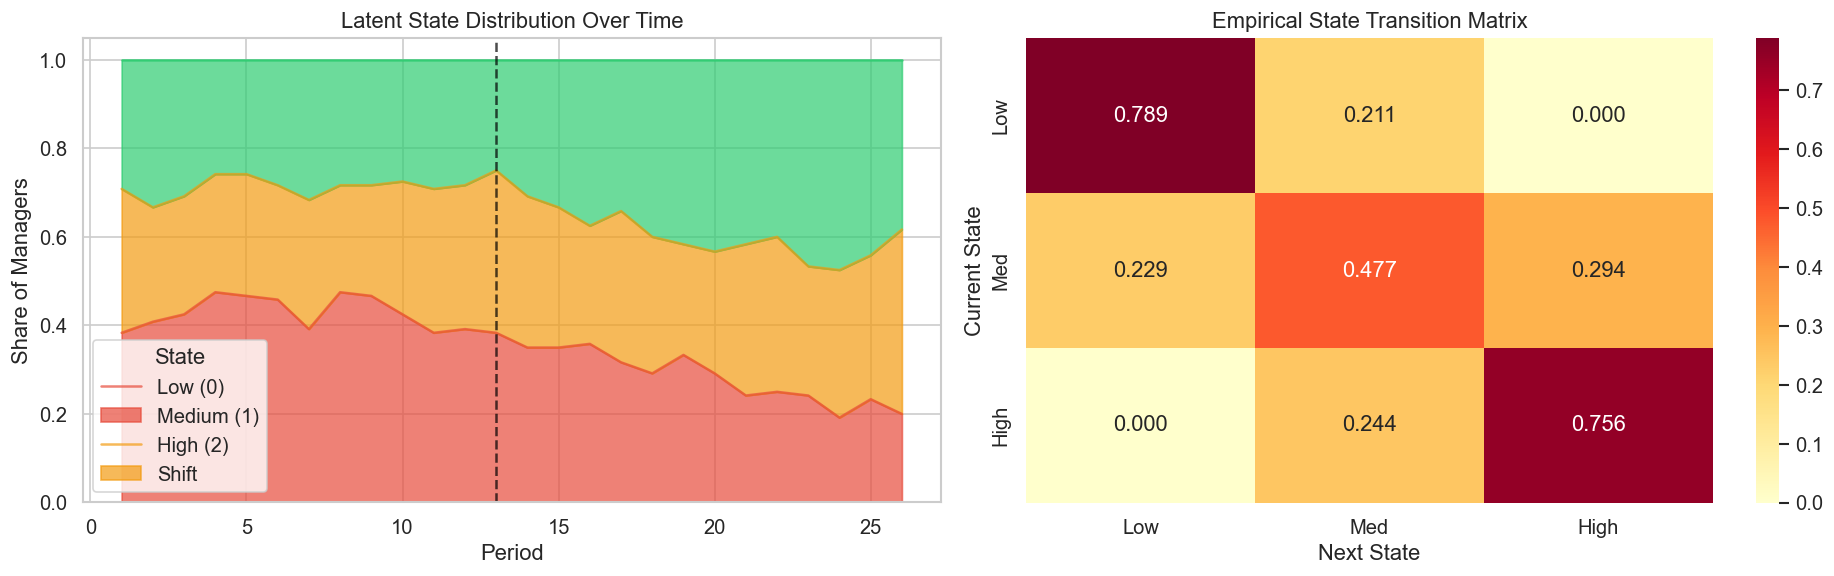

In [21]:
# Latent state distribution by period
state_dist = panel.groupby(["period_id", "latent_state"]).size().unstack(fill_value=0)
state_pct = state_dist.div(state_dist.sum(axis=1), axis=0)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Stacked area chart
state_pct.plot.area(ax=axes[0], alpha=0.7, color=["#e74c3c", "#f39c12", "#2ecc71"])
axes[0].axvline(x=13, color="black", linestyle="--", alpha=0.7, label="Transparency shift")
axes[0].set_title("Latent State Distribution Over Time")
axes[0].set_xlabel("Period")
axes[0].set_ylabel("Share of Managers")
axes[0].legend(title="State", labels=["Low (0)", "Medium (1)", "High (2)", "Shift"])

# Transition matrix: state → state_next
transitions = panel.groupby(["latent_state", "latent_state_next"]).size().unstack(fill_value=0)
trans_pct = transitions.div(transitions.sum(axis=1), axis=0).round(3)

sns.heatmap(trans_pct, annot=True, fmt=".3f", cmap="YlOrRd", ax=axes[1],
            xticklabels=["Low", "Med", "High"], yticklabels=["Low", "Med", "High"])
axes[1].set_title("Empirical State Transition Matrix")
axes[1].set_xlabel("Next State")
axes[1].set_ylabel("Current State")

plt.tight_layout()
plt.show()

## 7. Correlation Analysis

Correlation heatmap of key panel-level variables to identify relationships between delegation behavior, performance, and contextual factors.

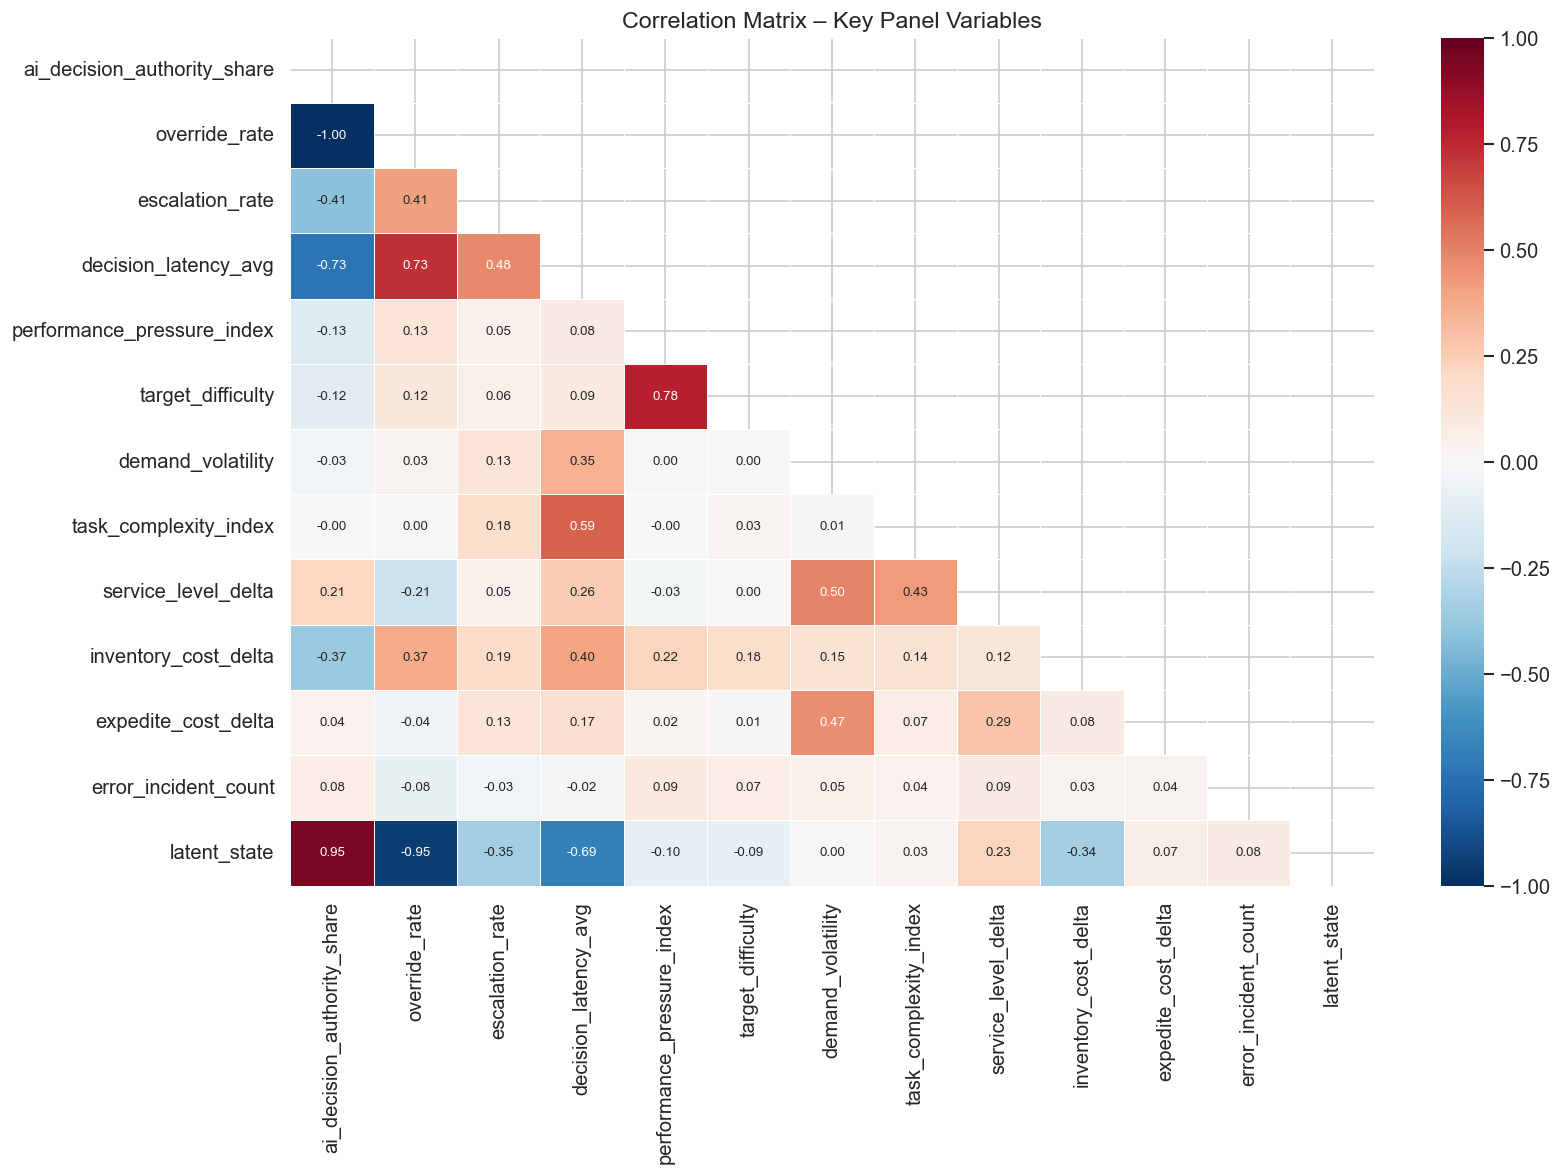

In [22]:
corr_cols = [
    "ai_decision_authority_share",
    "override_rate",
    "escalation_rate",
    "decision_latency_avg",
    "performance_pressure_index",
    "target_difficulty",
    "demand_volatility",
    "task_complexity_index",
    "service_level_delta",
    "inventory_cost_delta",
    "expedite_cost_delta",
    "error_incident_count",
    "latent_state",
]

corr_cols = [c for c in corr_cols if c in panel.columns]

corr_matrix = panel[corr_cols].corr().round(3)

fig, ax = plt.subplots(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    vmin=-1,
    vmax=1,
    ax=ax,
    linewidths=0.5,
    annot_kws={"size": 8},
)
ax.set_title("Correlation Matrix – Key Panel Variables", fontsize=14)
plt.tight_layout()
plt.show()